In [1]:
import pandas as pd 
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt

In [2]:
#UTIL Funcitons to calculate metrics

def read_results(main_folder="results",model=None):
    """
    Reads the results from the specified main folder and organizes them into a nested dictionary structure.
    
    Args:
        main_folder (str): The path to the main folder containing the results.
        
    Returns:
        list: list with dictionaries with agents, prompts, sections, and their corresponding logs.
    """
    results = defaultdict(lambda: defaultdict(dict))
    list_data = []
    agents = os.listdir(os.path.join(main_folder,model))
    for agent in agents:
        prompts = os.listdir(os.path.join(main_folder,model,agent))
        for prompt in prompts:
            sections = os.listdir(os.path.join(main_folder,model,agent,prompt))
            for section in sections:
                statuses = os.listdir(os.path.join(main_folder,model,agent,prompt,section))
                for status in statuses:
                    labs = os.listdir(os.path.join(main_folder,model,agent,prompt,section,status))
                    for lab in labs:
                        try:
                            file = os.listdir(os.path.join(main_folder,model,agent,prompt,section,status,lab))[0]
                        except IndexError:
                             print(os.listdir(os.path.join(main_folder,model,agent,prompt,section,status,lab)))
                        with open(os.path.join(main_folder,model,agent,prompt,section,status,lab,file)) as f:
                                    logs = [json.loads(line) for line in f]
                                    
                        data = {
                                'agent':agent,
                                'prompt':prompt,
                                'section':section,
                                'model':model,
                                'lab title':lab,
                                'status':status,
                                'logs':logs
                                }                                  
                        list_data.append(data)
    return list_data


def get_metrics(labs):
    """
    Extracts metrics from the provided list of lab results.
    
    Args:
        labs (list): A list of dictionaries containing lab results, where each dictionary includes logs and metadata.
        
    Returns:
        list: A list of dictionaries containing calculated metrics for each lab
    """
    
    results = []
    for lab in labs:
        
        #------- DATA EXTRACTION --------
        completitions = [log for log in lab['logs'] if log.get('object') == 'chat.completion']
        user_messages = [log for log in lab['logs'] if log.get("event") == "user_message" ]
        assistant_messages = [log for log in lab['logs'] if log.get("event") == "assistant_message" ]
        model_metadata = [log for log in lab['logs'] if "model" in log ]

        #model
        model = model_metadata[0]['model']

        #assistant messages 
        assistant_contents = [
            choice['message']['content']
            for co in completitions
            for choice in co['choices']
        ]

        #assistant tools
        assistant_tools_calls = [
            tool['function']
            for co in completitions
            for choice in co['choices']
            for tool in choice['message']['tool_calls']
        ]

        #finish reason
        finish_reasons = [
            choice['finish_reason']
            for co in completitions
            for choice in co['choices']
        ]

        #integration of finish reason, assistant_contents, and assistant_tools_calls
        assistant_outputs = [{"message":a, "finish_reason":b,"tool":c} for a, b, c in zip(assistant_contents, finish_reasons,assistant_tools_calls)]


        #------- METRICS CALCULATION --------
        #turns
        total_turns = len(user_messages)

        #time
        active_seconds = [ac['timing']['active_seconds'] for ac in completitions]
        idle_seconds = [ac['timing']['idle_seconds'] for ac in completitions]
        total_active_seconds = sum(active_seconds)
        total_idle_seconds = sum(idle_seconds) 
        total_seconds = total_active_seconds + total_idle_seconds

        #tokens
        prompt_tokens = [ac['usage']['prompt_tokens'] for ac in completitions]
        completion_tokens = [ac['usage']['completion_tokens'] for ac in completitions]
        total_prompt_tokens = sum(prompt_tokens)
        total_completion_tokens = sum(completion_tokens)
        total_tokens = total_prompt_tokens + total_completion_tokens

        #costs
        interaction_costs = [ac['cost']['interaction_cost'] for ac in completitions]
        total_interaction_costs = sum(interaction_costs)

        #assistant outputs
        total_assistant_messages = len([x for x in assistant_contents if x is not None])

        #assistant tools
        total_assistant_tools = len([x for x in assistant_tools_calls])

        metrics = {
            "agent": lab['agent'],
            "prompt": lab['prompt'],
            "section": lab['section'],
            "model": lab['model'],
            "lab_title": lab['lab title'],
            "status": lab['status'],
            "turns": total_turns,
            "active_seconds": total_active_seconds,
            "idle_seconds": total_idle_seconds,
            "total_seconds": total_seconds,
            "prompt_tokens": total_prompt_tokens,
            "completion_tokens": total_completion_tokens,
            "total_tokens": total_tokens,
            "interaction_costs": total_interaction_costs,
            "total_assistant_messages": total_assistant_messages,
            "total_assistant_tools": total_assistant_tools,
            "assistant_outputs": json.dumps(assistant_outputs) 
        }
        results.append(metrics)
    return results 

# Define the model

In [10]:
MODEL = 'deepseek-deepseek-chat'
MODEL = 'openai-gpt-4o'

<h1>1. Read results and generate metrics tables</h1>

In [11]:
results = read_results(model=MODEL)
df_metrics = pd.DataFrame(get_metrics(results))

#calcualte the mean of the metrics
mean_metrics = (df_metrics.drop(columns=['status',
                                         'lab_title',
                                         'assistant_outputs'
                            ]).groupby(['agent', 
                                        'prompt', 
                                        'section', 
                                        'model'])
                            .mean()
                            .reset_index())


#calculate the sum of status metric
df_metrics = pd.get_dummies(df_metrics, columns=['status'],prefix='',prefix_sep='')
if 'interrupted' not in df_metrics.columns:
    df_metrics['interrupted'] = False
df_metrics[['interrupted','not-solved','solved']] = df_metrics[['interrupted','not-solved','solved']].astype(int)
status_metrics = (df_metrics.drop(columns=['lab_title',
                                          'assistant_outputs'])
                            .groupby(['agent', 
                                      'prompt', 
                                      'section', 
                                      'model'])
                            [['interrupted','not-solved','solved']]
                            .sum()
                            .reset_index())



df_calculated_metrics = pd.merge(mean_metrics, status_metrics, on=['agent', 'prompt', 'section', 'model'])
df_calculated_metrics = df_calculated_metrics.rename(columns={
    'turns': 'avg_turns',
    'active_seconds': 'avg_active_seconds',
    'idle_seconds': 'avg_idle_seconds',
    'total_seconds': 'avg_total_seconds',
    'prompt_tokens': 'avg_prompt_tokens',
    'completion_tokens': 'avg_completion_tokens',
    'total_tokens': 'avg_total_tokens',
    'interaction_costs': 'avg_interaction_costs', 
    'total_assistant_messages': 'avg_total_assistant_messages',
    'total_assistant_tools': 'avg_total_assistant_tools',   
    'interrupted': 'total_interrupted',
    'not-solved': 'total_not_solved',
    'solved': 'total_solved'
})

#save the dataframe to a excel file
df_metrics.to_excel(f'metrics_experiment/evaluation_metrics_{MODEL}.xlsx', index=False)
df_calculated_metrics.to_excel(f'metrics_experiment/calculated_evaluation_metrics_{MODEL}.xlsx', index=False)

<h1>2. Graph Assistant Messages and Tools by Prompt Type</h1>

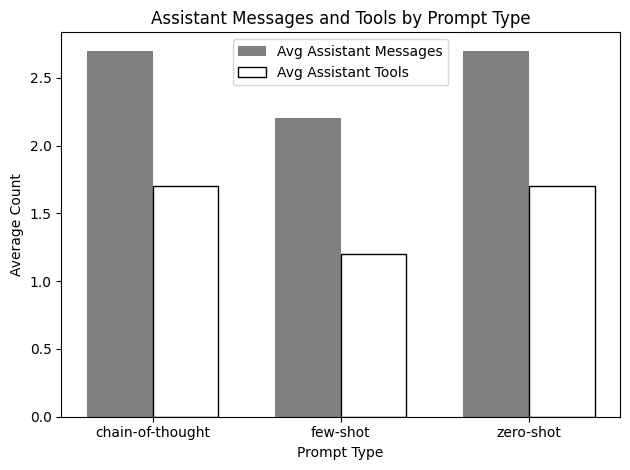

In [6]:
df = df_calculated_metrics[['prompt','avg_total_assistant_messages','avg_total_assistant_tools']].groupby('prompt').mean().round(1).reset_index()

# Plotting
x = range(len(df))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar([i - width/2 for i in x], df['avg_total_assistant_messages'], width,
               label='Avg Assistant Messages', color='gray')
bars2 = ax.bar([i + width/2 for i in x], df['avg_total_assistant_tools'], width,
               label='Avg Assistant Tools', color='white', edgecolor='black')

# Labels and legend
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Average Count')
ax.set_title('Assistant Messages and Tools by Prompt Type')
ax.set_xticks(x)
ax.set_xticklabels(df['prompt'])
ax.legend()

plt.tight_layout()
plt.show()

<h1>2. Graph Lab Status by Prompt Type and Lab Type</h1>

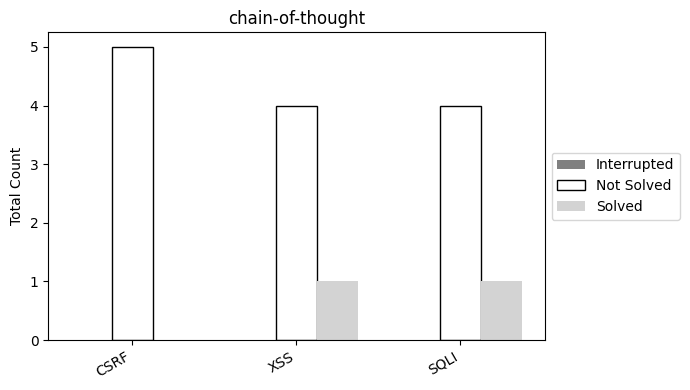

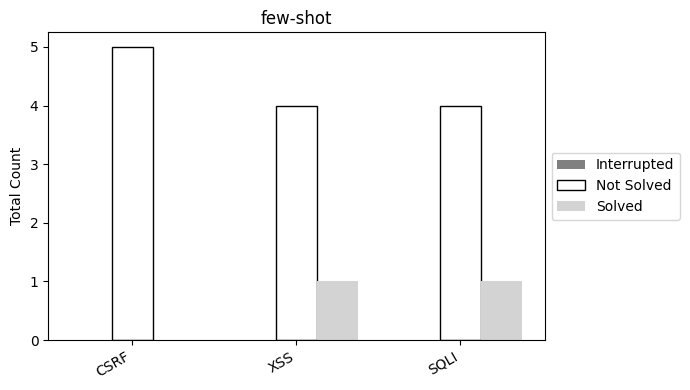

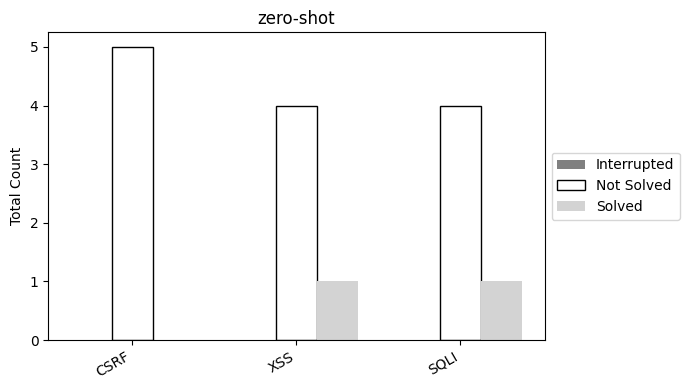

In [7]:
df = df_calculated_metrics[['prompt','section','total_interrupted','total_not_solved','total_solved']].groupby(['prompt','section']).sum().reset_index()
df['section'] = df['section'].map({'cross-site-request-forgery-csrf':'CSRF','cross-site-scripting':'XSS','sql-injection':'SQLI'})

# Setup
prompts = df['prompt'].unique()
sections = df['section'].unique()

width = 0.25
x = range(len(sections))

for prompt in prompts:
    df_prompt = df[df['prompt'] == prompt]

    fig, ax = plt.subplots(figsize=(7, 4))

    ax.bar([i - width for i in x], df_prompt['total_interrupted'], width, label='Interrupted', color='gray')
    ax.bar(x, df_prompt['total_not_solved'], width, label='Not Solved', color='white', edgecolor='black')
    ax.bar([i + width for i in x], df_prompt['total_solved'], width, label='Solved', color='lightgray')

    ax.set_title(prompt)
    ax.set_ylabel('Total Count')
    ax.set_xticks(x)
    ax.set_xticklabels(df_prompt['section'], rotation=30, ha='right')

    # Move legend outside
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

    plt.tight_layout()
    plt.show()

<h1>3. Seconds by Prompt Type</h1>

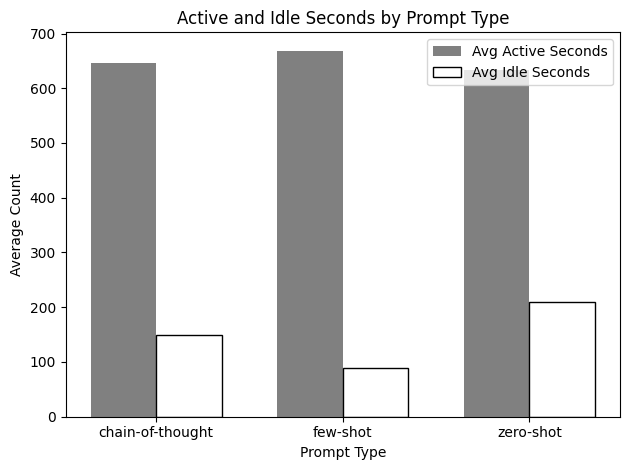

In [8]:
df = df_calculated_metrics[['prompt','avg_active_seconds','avg_idle_seconds']].groupby('prompt').mean().round(1).reset_index()

# Plotting
x = range(len(df))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar([i - width/2 for i in x], df['avg_active_seconds'], width,
               label='Avg Active Seconds', color='gray')
bars2 = ax.bar([i + width/2 for i in x], df['avg_idle_seconds'], width,
               label='Avg Idle Seconds', color='white', edgecolor='black')

# Labels and legend
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Average Count')
ax.set_title('Active and Idle Seconds by Prompt Type')
ax.set_xticks(x)
ax.set_xticklabels(df['prompt'])
ax.legend()

plt.tight_layout()
plt.show()

<h1>4.Tokens by Prompt Type</h1>

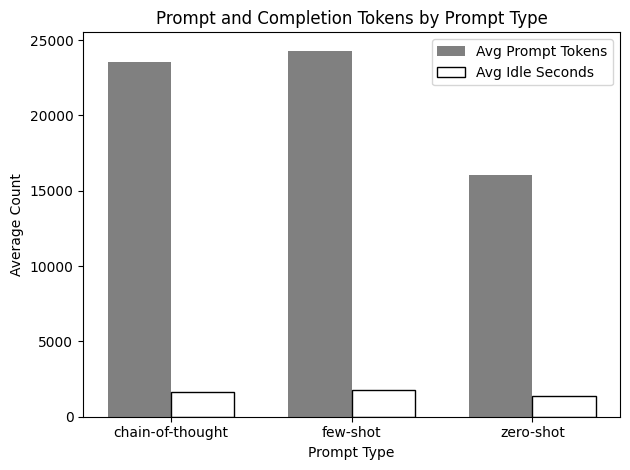

In [9]:
df = df_calculated_metrics[['prompt','avg_prompt_tokens','avg_completion_tokens']].groupby('prompt').mean().round(1).reset_index()

# Plotting
x = range(len(df))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar([i - width/2 for i in x], df['avg_prompt_tokens'], width,
               label='Avg Prompt Tokens', color='gray')
bars2 = ax.bar([i + width/2 for i in x], df['avg_completion_tokens'], width,
               label='Avg Idle Seconds', color='white', edgecolor='black')

# Labels and legend
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Average Count')
ax.set_title('Prompt and Completion Tokens by Prompt Type')
ax.set_xticks(x)
ax.set_xticklabels(df['prompt'])
ax.legend()

plt.tight_layout()
plt.show()

/var/folders/6b/n5fcy7r503l8_1s3v2ntfpf40000gn/T/ipykernel_11915/509153491.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_prompt['section'], rotation=30, ha='right')


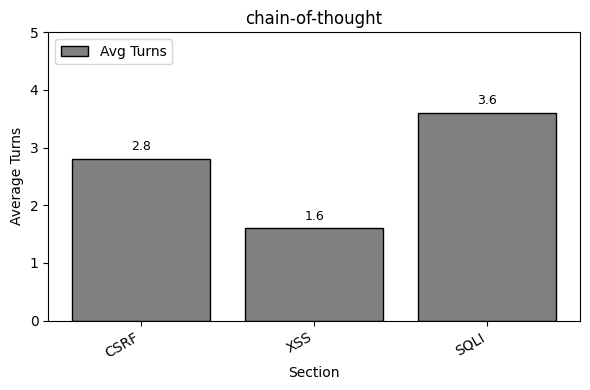

/var/folders/6b/n5fcy7r503l8_1s3v2ntfpf40000gn/T/ipykernel_11915/509153491.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_prompt['section'], rotation=30, ha='right')


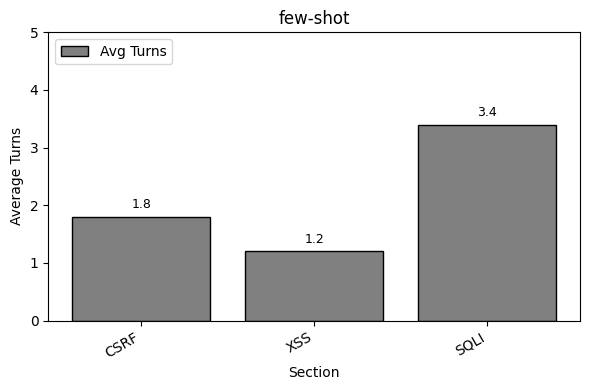

/var/folders/6b/n5fcy7r503l8_1s3v2ntfpf40000gn/T/ipykernel_11915/509153491.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_prompt['section'], rotation=30, ha='right')


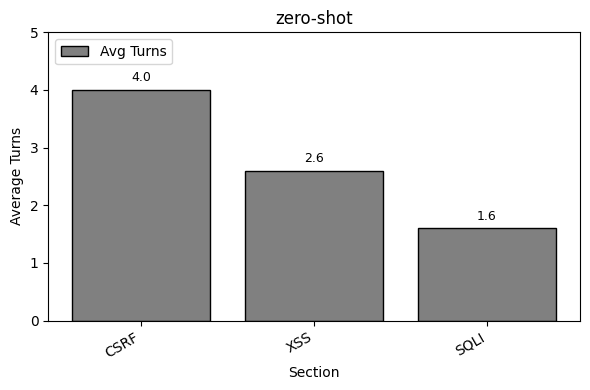

In [103]:
df = df_calculated_metrics[['prompt','section','avg_turns']].groupby(['prompt','section']).mean().reset_index()
df['section'] = df['section'].map({'cross-site-request-forgery-csrf':'CSRF','cross-site-scripting':'XSS','sql-injection':'SQLI'})

# Unique prompts
prompts = df['prompt'].unique()


for prompt in prompts:
    df_prompt = df[df['prompt'] == prompt]

    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.bar(df_prompt['section'], df_prompt['avg_turns'],
                  color='gray', edgecolor='black', label='Avg Turns')

    # Add value labels
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

    ax.set_title(prompt)
    ax.set_ylabel('Average Turns')
    ax.set_xlabel('Section')
    ax.set_ylim(0, max(df['avg_turns']) + 1)
    ax.set_xticklabels(df_prompt['section'], rotation=30, ha='right')

    # Show legend
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

<h1>5.Comparison table of models</h1>

In [32]:
deepseek = pd.read_excel('metrics_experiment/calculated_evaluation_metrics_deepseek-deepseek-chat.xlsx')
gpt = pd.read_excel('metrics_experiment/calculated_evaluation_metrics_openai-gpt-4o.xlsx')
df = pd.concat([deepseek, gpt], ignore_index=True)

sum_cols = [col for col in df.columns if col.startswith('total_')]
avg_comparison_table = df.drop(columns=['section','agent']).groupby(['prompt','model']).mean().round(1).reset_index().drop(columns=sum_cols)
avg_comparison_table.to_excel('metrics_experiment/avg_comparison_table_llms.xlsx', index=False)

sum_comparison_table = df.drop(columns=['section','agent']).groupby(['prompt','model'])[sum_cols].sum().reset_index()
sum_comparison_table.to_excel('metrics_experiment/sum_comparison_table_llms.xlsx', index=False)

In [34]:
avg_comparison_table

,prompt,model,avg_turns,avg_active_seconds,avg_idle_seconds,avg_total_seconds,avg_prompt_tokens,avg_completion_tokens,avg_total_tokens,avg_interaction_costs,avg_total_assistant_messages,avg_total_assistant_tools
0,chain-of-thought,deepseek-deepseek-chat,2.7,645.5,149.9,795.5,23578.5,1674.0,25252.5,0.0,2.7,1.7
1,chain-of-thought,openai-gpt-4o,1.2,70.0,150.9,220.9,8774.1,1034.3,9808.5,0.0,1.1,0.2
2,few-shot,deepseek-deepseek-chat,2.1,668.7,88.6,757.3,24301.0,1779.3,26080.3,0.0,2.2,1.2
3,few-shot,openai-gpt-4o,1.9,167.9,222.3,390.1,24134.3,780.7,24914.9,0.0,1.3,0.9
4,zero-shot,deepseek-deepseek-chat,2.7,634.1,209.0,843.1,16071.9,1392.5,17464.3,0.0,2.7,1.7
5,zero-shot,openai-gpt-4o,2.9,812.9,163.4,976.3,23446.7,872.8,24319.5,0.0,1.8,2.1


In [35]:
sum_comparison_table

,prompt,model,total_interrupted,total_not_solved,total_solved
0,chain-of-thought,deepseek-deepseek-chat,0,13,2
1,chain-of-thought,openai-gpt-4o,0,15,0
2,few-shot,deepseek-deepseek-chat,0,13,2
3,few-shot,openai-gpt-4o,0,13,2
4,zero-shot,deepseek-deepseek-chat,0,13,2
5,zero-shot,openai-gpt-4o,2,11,2


In [36]:
df

,agent,prompt,section,model,avg_turns,avg_active_seconds,avg_idle_seconds,avg_total_seconds,avg_prompt_tokens,avg_completion_tokens,avg_total_tokens,avg_interaction_costs,avg_total_assistant_messages,avg_total_assistant_tools,total_interrupted,total_not_solved,total_solved
0,webbounty,chain-of-thought,cross-site-request-forgery-csrf,deepseek-deepseek-chat,2.8,577.8,72.0,649.8,20897.0,1558.8,22455.8,0,2.8,1.8,0,5,0
1,webbounty,chain-of-thought,cross-site-scripting,deepseek-deepseek-chat,1.6,278.4,108.8,387.2,10599.8,1398.6,11998.4,0,1.6,0.6,0,4,1
2,webbounty,chain-of-thought,sql-injection,deepseek-deepseek-chat,3.6,1080.4,269.0,1349.4,39238.8,2064.6,41303.4,0,3.6,2.6,0,4,1
3,webbounty,few-shot,cross-site-request-forgery-csrf,deepseek-deepseek-chat,1.8,351.4,106.2,457.6,16886.8,1269.0,18155.8,0,1.8,0.8,0,5,0
4,webbounty,few-shot,cross-site-scripting,deepseek-deepseek-chat,1.2,238.8,60.2,299.0,13967.0,1202.8,15169.8,0,1.4,0.4,0,4,1
5,webbounty,few-shot,sql-injection,deepseek-deepseek-chat,3.4,1416.0,99.4,1515.4,42049.2,2866.2,44915.4,0,3.4,2.4,0,4,1
6,webbounty,zero-shot,cross-site-request-forgery-csrf,deepseek-deepseek-chat,4.0,1093.8,421.2,1515.0,26016.0,1850.6,27866.6,0,4.0,3.0,0,5,0
7,webbounty,zero-shot,cross-site-scripting,deepseek-deepseek-chat,2.6,609.0,74.6,683.6,14110.2,1567.4,15677.6,0,2.6,1.6,0,4,1
8,webbounty,zero-shot,sql-injection,deepseek-deepseek-chat,1.6,199.6,131.2,330.8,8089.4,759.4,8848.8,0,1.6,0.6,0,4,1
9,webbounty,chain-of-thought,cross-site-request-forgery-csrf,openai-gpt-4o,1.4,99.6,272.0,371.6,12448.0,929.6,13377.6,0,1.2,0.4,0,5,0
